[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/Univariate_Temperature_Lags.ipynb)

# Univariate Temperature Example (Lags/Window Method)
--------------------------------------------------
**Dr. Dave Wanik - University of Connecticut**

Let's see if we can predict the temperature as a function of N previous days.

In [1]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Read in data
Check for missing values, make some plots.

In [ ]:
# Dataset initially sourced from jbrownlee’s GitHub repository:
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module4_Files/daily-min-temperatures.csv"

# read the data
df = pd.read_csv(url)
print(df.info())
df.head(n=15) # nice complete data! this will allow us to check our work later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB
None


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


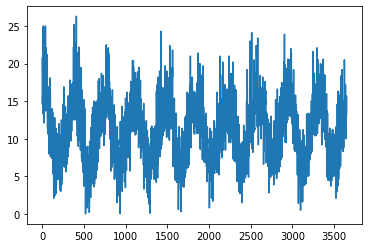

In [ ]:
# visualize the data
df['Temp'].plot()
plt.show()

In [ ]:
# univariate lags ('series_to_supervised')
# link: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# here's what the code does for a lag of 1
values = [x for x in range(10)]
values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
data = series_to_supervised(values, # the univariate dataset
                            n_in=1, # this means how many previous lags do you want
                            n_out=1) # this means how many steps ahead do you want to forecast (1 means current timestep)
print(data)

   var1(t-1)  var1(t)
1        0.0        1
2        1.0        2
3        2.0        3
4        3.0        4
5        4.0        5
6        5.0        6
7        6.0        7
8        7.0        8
9        8.0        9


In [ ]:
# here's what the code does for a lag of 3
values = [x for x in range(10)]
data = series_to_supervised(values, # the univariate dataset
                            n_in=3, # this means how many previous lags do you want
                            n_out=1) # this means how many steps ahead do you want to forecast (1 means current timestep)
print(data)

   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3        0.0        1.0        2.0        3
4        1.0        2.0        3.0        4
5        2.0        3.0        4.0        5
6        3.0        4.0        5.0        6
7        4.0        5.0        6.0        7
8        5.0        6.0        7.0        8
9        6.0        7.0        8.0        9


In [ ]:
tmp = df['Temp']
tmp = pd.DataFrame(tmp)
tmp.head()

,Temp
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8


In [ ]:
# now let's use is on our datasaet
# let's use 10 lags (assume data is on a regular temporal scale)
# make sure the input is a pandas dataframe!
tmp = series_to_supervised(tmp, # the univariate dataset
                            n_in=10, # this means how many previous lags do you want
                            n_out=1)
tmp.head()

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
10,20.7,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2
11,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3
12,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7
13,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5
14,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0


In [ ]:
# split data into X and Y
y = tmp['var1(t)']
X = tmp.drop(['var1(t)'], axis=1)
print(X.shape, y.shape)

(3640, 10) (3640,)


In [ ]:
# now split into train and test partition
# split the data into train and test partitions
# we will use 90% of the data for train, and 10% for validation
train_pct_index = int(0.9 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# Dense Neural Network

In [ ]:
# now let's build a model

# define model
model = Sequential()
model.add(Dense(30, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=10,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
262/262 [==============================] - 2s 5ms/step - loss: 42.3267 - mae: 4.1593 - val_loss: 6.0021 - val_mae: 1.9458
Epoch 2/500
262/262 [==============================] - 1s 5ms/step - loss: 6.8140 - mae: 2.0534 - val_loss: 5.7774 - val_mae: 1.8889
Epoch 3/500
262/262 [==============================] - 1s 6ms/step - loss: 6.5754 - mae: 2.0150 - val_loss: 5.6625 - val_mae: 1.8817
Epoch 4/500
262/262 [==============================] -

MAE:  1.7661590927249782


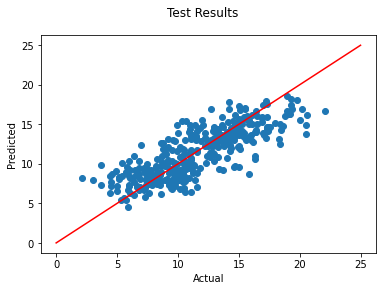

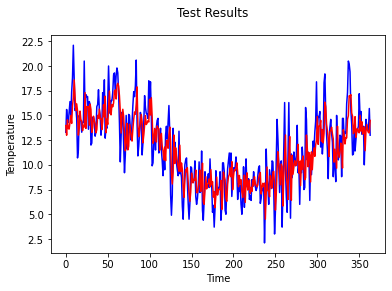

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

Of course, you could play around with more lags and even try polynomial features or other scaling to get this to work. Heck, once your data is prepped, you can even try TPOT to see if you can get a better architecture then what you are evaluating.